In [1]:
import h5py
import numpy as np
import os,random
from tensorflow.keras.layers import Input,Add,Reshape,AveragePooling2D,ZeroPadding2D,BatchNormalization,MaxPool2D,Conv1D,Conv2D,Dropout,Flatten,Dense,Activation,MaxPooling2D,AlphaDropout
from tensorflow.keras import layers
import tensorflow.keras.models as Model
from tensorflow.keras.regularizers import *
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.initializers import GlorotUniform as glorot_uniform
import seaborn as sns
import tensorflow as tf
import matplotlib.pyplot as plt
from tensorflow.keras.models import load_model
import tensorflow_addons as tfa

In [2]:
f = h5py.File('ExtractDataset/part0.h5')
sample_num = f['X'].shape[0]
# idx = np.random.choice(range(0,sample_num),size=3375)
idx = np.random.choice(range(0,sample_num),size=60000)
X = f['X'][:][idx]
Y = f['Y'][:][idx]
Z = f['Z'][:][idx]
f.close()

for i in range(1,24):
    if i%1 == 0:
        !free -m
    '''if i == 10:
        continue'''
    filename = 'ExtractDataset/part'+str(i) + '.h5'
    print(filename)
    f = h5py.File(filename,'r')
    X = np.vstack((X,f['X'][:][idx]))
    Y = np.vstack((Y,f['Y'][:][idx]))
    Z = np.vstack((Z,f['Z'][:][idx]))
    f.close()


print('X-size：',X.shape)
print('Y-size：',Y.shape)
print('Z-size：',Z.shape)

'free' is not recognized as an internal or external command,
operable program or batch file.


ExtractDataset/part1.h5


'free' is not recognized as an internal or external command,
operable program or batch file.


ExtractDataset/part2.h5


'free' is not recognized as an internal or external command,
operable program or batch file.


ExtractDataset/part3.h5


'free' is not recognized as an internal or external command,
operable program or batch file.


ExtractDataset/part4.h5


'free' is not recognized as an internal or external command,
operable program or batch file.


ExtractDataset/part5.h5


'free' is not recognized as an internal or external command,
operable program or batch file.


ExtractDataset/part6.h5


'free' is not recognized as an internal or external command,
operable program or batch file.


ExtractDataset/part7.h5


'free' is not recognized as an internal or external command,
operable program or batch file.


ExtractDataset/part8.h5


'free' is not recognized as an internal or external command,
operable program or batch file.


ExtractDataset/part9.h5


'free' is not recognized as an internal or external command,
operable program or batch file.


ExtractDataset/part10.h5


'free' is not recognized as an internal or external command,
operable program or batch file.


ExtractDataset/part11.h5


'free' is not recognized as an internal or external command,
operable program or batch file.


ExtractDataset/part12.h5


'free' is not recognized as an internal or external command,
operable program or batch file.


ExtractDataset/part13.h5


'free' is not recognized as an internal or external command,
operable program or batch file.


ExtractDataset/part14.h5


'free' is not recognized as an internal or external command,
operable program or batch file.


ExtractDataset/part15.h5


'free' is not recognized as an internal or external command,
operable program or batch file.


ExtractDataset/part16.h5


'free' is not recognized as an internal or external command,
operable program or batch file.


ExtractDataset/part17.h5


'free' is not recognized as an internal or external command,
operable program or batch file.


ExtractDataset/part18.h5


'free' is not recognized as an internal or external command,
operable program or batch file.


ExtractDataset/part19.h5


'free' is not recognized as an internal or external command,
operable program or batch file.


ExtractDataset/part20.h5


'free' is not recognized as an internal or external command,
operable program or batch file.


ExtractDataset/part21.h5


'free' is not recognized as an internal or external command,
operable program or batch file.


ExtractDataset/part22.h5


'free' is not recognized as an internal or external command,
operable program or batch file.


ExtractDataset/part23.h5
X-size： (1440000, 1024, 2)
Y-size： (1440000, 24)
Z-size： (1440000, 1)


## Data preprocessing, and obtain training set and test set

In [3]:
n_examples = X.shape[0]
# n_train = int(n_examples * 0.9877) 
n_train = int(n_examples * 0.8)  
train_idx = np.random.choice(range(0,n_examples), size=n_train, replace=False)  #Randomly select training sample subscript
test_idx = list(set(range(0,n_examples))-set(train_idx)) #Test sample index
X_train = X[train_idx]  #training samples
X_test =  X[test_idx]  #testing samples
Y_train = Y[train_idx]
Y_test = Y[test_idx]
print("X_train:",X_train.shape)
print("Y_train:",Y_train.shape)
print("X_test:",X_test.shape)
print("Y_test:",Y_test.shape)

X_train: (1152000, 1024, 2)
Y_train: (1152000, 24)
X_test: (288000, 1024, 2)
Y_test: (288000, 24)


In [4]:
X_train[0]

array([[ 0.24300517, -0.19267955],
       [ 0.00614425, -0.00558631],
       [-0.2235421 ,  0.17797543],
       ...,
       [ 0.9210267 , -0.45695648],
       [ 0.7268512 , -0.3598473 ],
       [ 0.50521183, -0.24862258]], dtype=float32)

In [5]:
X_train.shape[1:] 
# Input(in_shp)

(1024, 2)

In [6]:
units = round((X_train.shape[0])/(0.2*(X_train.shape[1]+X_train.shape[2])))
units/7

802.0

In [7]:
classes = ['32PSK',
 '16APSK',
 '32QAM',
 'FM',
 'GMSK',
 '32APSK',
 'OQPSK',
 '8ASK',
 'BPSK',
 '8PSK',
 'AM-SSB-SC',
 '4ASK',
 '16PSK',
 '64APSK',
 '128QAM',
 '128APSK',
 'AM-DSB-SC',
 'AM-SSB-WC',
 '64QAM',
 'QPSK',
 '256QAM',
 'AM-DSB-WC',
 'OOK',
 '16QAM']

   
def residual_stack(X,Filters,Seq,max_pool):
    #1*1 Conv Linear
    X = Conv2D(Filters, (1, 1), padding='same', name=Seq+"_conv1", kernel_initializer='glorot_uniform',data_format="channels_first")(X)
    X = BatchNormalization(axis = 3)(X)

    #Residual Unit 1
    X_shortcut = X
    X = Conv2D(Filters, (3, 2), padding='same',activation="relu",name=Seq+"_conv2", kernel_initializer='glorot_uniform',data_format="channels_first")(X)
    X = Conv2D(Filters, (3, 2), padding='same', name=Seq+"_conv3", kernel_initializer='glorot_uniform',data_format="channels_first")(X)
    X = BatchNormalization(axis = 3)(X)

    X = layers.add([X,X_shortcut])
    X = Activation("relu")(X)
    #Residual Unit 2
    X_shortcut = X
    X = Conv2D(Filters, (3, 2), padding='same',activation="relu",name=Seq+"_conv4", kernel_initializer='glorot_uniform',data_format="channels_first")(X)
    X = Conv2D(Filters, (3, 2), padding='same', name=Seq+"_conv5", kernel_initializer='glorot_uniform',data_format="channels_first")(X)
    X = BatchNormalization(axis = 3)(X)

    
    X = layers.add([X,X_shortcut])
    X = Activation("relu")(X)
    #MaxPooling
    if max_pool:
        X = MaxPooling2D(pool_size=(2, 1), strides=(2, 1), padding='valid', data_format="channels_first")(X)
    return X

mirrored_strategy = tf.distribute.MirroredStrategy(devices=["/gpu:0","/gpu:1","/gpu:2"], cross_device_ops=tf.distribute.HierarchicalCopyAllReduce())

with mirrored_strategy.scope():
    in_shp = X_train.shape[1:]   #Dimensions of each sample
    #input layer
    X_input = Input(in_shp)
    X = Reshape([1,1024,2], input_shape=in_shp)(X_input)
    #Residual Srack 1
    X = residual_stack(X,32,"ReStk1",False)  #shape:(1,512,32)
    X = MaxPooling2D(pool_size=(2, 2), strides=(2, 1), padding='valid', data_format="channels_first")(X)
    #Residual Srack 2
    X = residual_stack(X,32,"ReStk2",True)  #shape:(1,256,32)
    #Residual Srack 3
    X = residual_stack(X,64,"ReStk3",True)  #shape:(1,128,32)
    #Residual Srack 4
    X = residual_stack(X,64,"ReStk4",True)  #shape:(1,64,32)
    #Residual Srack 5
    # X = residual_stack(X,32,"ReStk5",True)  #shape:(1,32,32)
    # #Residual Srack 6
    # X = residual_stack(X,32,"ReStk6",True)  #shape:(1,16,32)
    #Full Con 1
    X = Flatten()(X)
    X = Dense(128, activation='selu', kernel_initializer='he_normal', name="dense1")(X)
    X = Dropout(0.3)(X)
    #Full Con 2
    X = Dense(128, activation='selu', kernel_initializer='he_normal', name="dense2")(X)
    X = Dropout(0.3)(X)
    #Full Con 3
    X = Dense(len(classes), kernel_initializer='he_normal', name="dense3")(X)
    #SoftMax
    X = Activation('softmax')(X)
    #Create Model
    model = Model.Model(inputs=X_input,outputs=X)
model.load_weights('resnet2_model.h5')
model.compile(loss='categorical_crossentropy', optimizer=tfa.optimizers.LazyAdam(),metrics=['accuracy'])
model.summary()

INFO:tensorflow:Using MirroredStrategy with devices ('/job:localhost/replica:0/task:0/device:GPU:0', '/job:localhost/replica:0/task:0/device:GPU:1', '/job:localhost/replica:0/task:0/device:GPU:2')
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localho

 max_pooling2d_1 (MaxPooling2D)  (None, 32, 256, 1)  0           ['activation_3[0][0]']           
                                                                                                  
 ReStk3_conv1 (Conv2D)          (None, 64, 256, 1)   2112        ['max_pooling2d_1[0][0]']        
                                                                                                  
 batch_normalization_6 (BatchNo  (None, 64, 256, 1)  4           ['ReStk3_conv1[0][0]']           
 rmalization)                                                                                     
                                                                                                  
 ReStk3_conv2 (Conv2D)          (None, 64, 256, 1)   24640       ['batch_normalization_6[0][0]']  
                                                                                                  
 ReStk3_conv3 (Conv2D)          (None, 64, 256, 1)   24640       ['ReStk3_conv2[0][0]']           
          

In [10]:
from tensorflow.keras.utils import plot_model
model = load_model('resnet2_model.h5')
plot_model(model, to_file='model_plot.png', show_shapes=True, show_layer_names=True)

You must install pydot (`pip install pydot`) and install graphviz (see instructions at https://graphviz.gitlab.io/download/) for plot_model/model_to_dot to work.


In [11]:
%%time
filepath = 'resnet2_model.h5'
history = model.fit(X_train,
    Y_train,
    batch_size=1024,
    epochs=5,
    verbose=1,
#     validation_data=(X_test, Y_test),
    validation_split = 0.2,
    callbacks = [
        tf.keras.callbacks.ModelCheckpoint(filepath, monitor='val_loss', verbose=1, save_best_only=True, mode='auto'),
        tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=10, verbose=1, mode='auto')
    ])

Epoch 1/5
900/900 [==============================] - ETA: 0s - loss: 1.2570 - accuracy: 0.5878 
Epoch 1: val_loss improved from inf to 1.26129, saving model to resnet2_model.h5
900/900 [==============================] - 18829s 21s/step - loss: 1.2570 - accuracy: 0.5878 - val_loss: 1.2613 - val_accuracy: 0.5838
Epoch 2/5
  8/900 [..............................] - ETA: 4:40:05 - loss: 1.2437 - accuracy: 0.5973

KeyboardInterrupt: 

In [ ]:
fig, ((ax1, ax2)) = plt.subplots(nrows=1, ncols=2,figsize=(20,6))

ax1.plot(history.history['accuracy'],'b', history.history['val_accuracy'], 'r')
ax1.set_ylabel('Accuracy Rate',fontsize=12)
ax1.set_xlabel('Iteration',fontsize=12)
ax1.set_title('Categorical Cross Entropy ',fontsize=14)
ax1.legend(['Training Accuracy','Validation Accuracy'],fontsize=12,loc='best')

ax2.plot(history.history['loss'], 'b',history.history['val_loss'],'r')
ax2.set_ylabel('Loss',fontsize=12)
ax2.set_xlabel('Iteration',fontsize=12)
ax2.set_title('Learning Curve ',fontsize=14)
ax2.legend(['Training Loss','Validation Loss'],fontsize=12,loc='best')

# plt.savefig('crosse_results.png')
plt.show()

In [8]:

filepath = 'resnet2_model.h5'
model_resnet = load_model(filepath)


In [ ]:
def plot_confusion_matrix(cm, title='Confusion matrix', cmap=plt.cm.Blues, labels=[]):
    plt.figure(figsize=(10, 10))
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(labels))
    plt.xticks(tick_marks, labels, rotation=45)
    plt.yticks(tick_marks, labels)
    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
# Plot confusion matrix
batch_size = 1024
test_Y_hat = model.predict(X_test, batch_size=3000)
conf = np.zeros([len(classes),len(classes)])
confnorm = np.zeros([len(classes),len(classes)])
for i in range(0,X_test.shape[0]):
    j = list(Y_test[i,:]).index(1)
    k = int(np.argmax(test_Y_hat[i,:]))
    conf[j,k] = conf[j,k] + 1
for i in range(0,len(classes)):
    confnorm[i,:] = conf[i,:] / np.sum(conf[i,:])
plot_confusion_matrix(confnorm, labels=classes)

96/96 [==============================] - 884s 9s/step


In [26]:
for i in range(len(confnorm)):
    print(classes[i],confnorm[i,i])

32PSK 0.742526438504455
16APSK 0.6412462412295356
32QAM 0.7072192513368984
FM 0.757015516672169
GMSK 0.6507949790794979
32APSK 0.6027160493827161
OQPSK 0.5929078014184397
8ASK 0.5838504108670133
BPSK 0.6397120375020927
8PSK 0.619023862974973
AM-SSB-SC 0.5743981595596089
4ASK 0.5397679502270052
16PSK 0.5838410817127118
64APSK 0.5766233766233766
128QAM 0.49491072918404805
128APSK 0.5101736972704715
AM-DSB-SC 0.5058178191489362
AM-SSB-WC 0.19072078140788143
64QAM 0.773004617414248
QPSK 0.6698184888138455
256QAM 0.6133300049925112
AM-DSB-WC 0.7772958545333222
OOK 0.7427581084426839
16QAM 0.7061148961224661


In [ ]:
classes = ['32PSK',
 '16APSK',
 '32QAM',
 'FM',
 'GMSK',
 '32APSK',
 'OQPSK',
 '8ASK',
 'BPSK',
 '8PSK',
 'AM-SSB-SC',
 '4ASK',
 '16PSK',
 '64APSK',
 '128QAM',
 '128APSK',
 'AM-DSB-SC',
 'AM-SSB-WC',
 '64QAM',
 'QPSK',
 '256QAM',
 'AM-DSB-WC',
 'OOK',
 '16QAM']
def plot_confusion_matrix(cm, title='Confusion matrix', cmap=plt.cm.Blues, labels=[]):
    plt.figure(figsize=(10, 10))
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(labels))
    plt.xticks(tick_marks, labels, rotation=45)
    plt.yticks(tick_marks, labels)
    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
acc={}
Z_test = Z[test_idx]
Z_test = Z_test.reshape((len(Z_test)))
SNRs = np.unique(Z_test)
for snr in SNRs:
    X_test_snr = X_test[Z_test==snr]
    Y_test_snr = Y_test[Z_test==snr]
    
    pre_Y_test = model.predict(X_test_snr)
    conf = np.zeros([len(classes),len(classes)])
    confnorm = np.zeros([len(classes),len(classes)])
    for i in range(0,X_test_snr.shape[0]):    
        j = list(Y_test_snr[i,:]).index(1)   
        k = int(np.argmax(pre_Y_test[i,:])) 
        conf[j,k] = conf[j,k] + 1
    for i in range(0,len(classes)):
        confnorm[i,:] = conf[i,:] / np.sum(conf[i,:])
   
    plt.figure()
    plot_confusion_matrix(confnorm, labels=classes, title="ConvNet Confusion Matrix (SNR=%d)"%(snr))
    
    cor = np.sum(np.diag(conf))
    ncor = np.sum(conf) - cor
    print ("Overall Accuracy %s: "%snr, cor / (cor+ncor))
    acc[snr] = 1.0*cor/(cor+ncor)

351/351 [==============================] - 48s 135ms/step


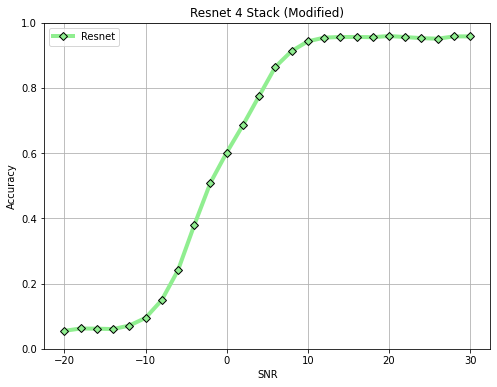

In [29]:
plt.figure(figsize=(8,6))
plt.plot(acc.keys(),acc.values(),linewidth=4,color='lightgreen', marker='D', markeredgecolor='black')
plt.ylim(0, 1) 
plt.ylabel('Accuracy')
plt.xlabel('SNR')
plt.title('Resnet 4 Stack (Modified)')
plt.grid()
plt.legend(['Resnet'],loc='upper left')
plt.show()

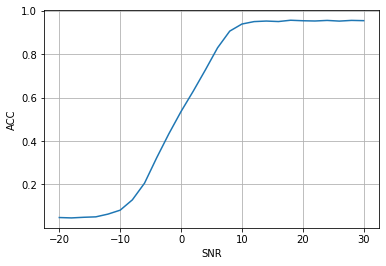

In [20]:

plt.plot(acc.keys(),acc.values())
plt.ylabel('ACC')
plt.xlabel('SNR')
plt.grid(True)
plt.show()

In [9]:
import matplotlib as mpl
import matplotlib.pyplot as plt

loss_object = tf.keras.losses.CategoricalCrossentropy()
def create_adversarial_pattern(input_value, Yval):
  with tf.GradientTape() as tape:
    tape.watch(input_value)
    prediction = model_resnet(input_value)
    loss = loss_object(Yval, prediction)

  gradient = tape.gradient(loss, input_value)
  signed_grad = tf.sign(gradient)
  return signed_grad

In [ ]:



acc={}
Z_test = Z[test_idx]
Z_test = Z_test.reshape((len(Z_test)))
SNRs = np.unique(Z_test)
for snr in SNRs:
    
    if snr == 30:
        X_test_snr = X_test[Z_test==snr]
        X_tmp = X_test_snr
        Y_test_snr = Y_test[Z_test==snr]
        X_test_snr = tf.convert_to_tensor(X_test_snr)
        Y_test_snr = tf.convert_to_tensor(Y_test_snr)
        perturbations = create_adversarial_pattern(X_test_snr, Y_test_snr)
    
        pre_Y_test_resnet = model_resnet.predict(perturbations)
    
        conf = np.zeros([len(classes),len(classes)])
        confnorm = np.zeros([len(classes),len(classes)])
        for i in range(0,X_test_snr.shape[0]):   
            j = list(Y_test_snr[i,:]).index(1)   
            k = int(np.argmax(perturbations[i,:]))  
       
            conf[j,k] = conf[j,k] + 1
        for i in range(0,len(classes)):
            confnorm[i,:] = conf[i,:] / np.sum(conf[i,:])
   
    #plt.figure()
    #plot_confusion_matrix(confnorm, labels=classes, title="ConvNet Confusion Matrix (SNR=%d)"%(snr))
    
        cor = np.sum(np.diag(conf))
        ncor = np.sum(conf) - cor
        print ("Overall Accuracy %s: "%snr, cor / (cor+ncor))
        acc[snr] = 1.0*cor/(cor+ncor)
    
    